## Intro
In this notebook I will be exploring a character level recurrent sequence to sequence model. I will be using it to translate fairly short english sentences to french sentences.  Much of the code to build the model I found from the link https://keras.io/examples/nlp/lstm_seq2seq/

In [27]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings

The data used is from http://www.manythings.org/anki/ and is of the form of an English sentence corresponding with a French sentence along with the place from which this relationship was found, which we will not care about moving forwards.

In [ ]:
batch_size = 64  
epochs = 100  
latent_dim = 256 
num_samples = 10000  

data_path = "C://Users//benma//Desktop//5720 pics//fra.txt"

As usual, I will first need to vectorize the data.

In [ ]:
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
    # "tab" indicates the start of the sequence
    # \n indicates the end of the sequence
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

Just to show what the form of the data is, I will do a very limited amount of data exploration.

In [30]:
print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 93
Max sequence length for inputs: 15
Max sequence length for outputs: 59


In [35]:
lines[0:50]

['Go.\tVa !\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)',
 'Go.\tMarche.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8090732 (Micsmithel)',
 'Go.\tBouge !\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #9022935 (Micsmithel)',
 'Hi.\tSalut !\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #509819 (Aiji)',
 'Hi.\tSalut.\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #4320462 (gillux)',
 'Run!\tCours\u202f!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906331 (sacredceltic)',
 'Run!\tCourez\u202f!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906332 (sacredceltic)',
 'Run!\tPrenez vos jambes à vos cous !\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #2077449 (sacredceltic)',
 'Run!\tFile !\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #2077454 (sacredceltic)',
 'Run!\tFilez !\tCC-BY 2.0 (France) Attribution: tatoeba

We see that the first lines are the shortest sentences, which we will be focussing on more than the longer ones. Also notice how many sentences occur a few times. The reason for this is simple, there are often multiple translations for the same meaning of a sentence.

In [36]:
lines[-50:]

["I used to watch this anime a lot when I was a kid, but I can't quite remember what happened to the hero in the final episode.\tJ'avais l'habitude de beaucoup regarder ce dessin animé quand j'étais enfant, mais je ne peux plus trop me rappeler ce qui est arrivé au héros dans l'ultime épisode.\tCC-BY 2.0 (France) Attribution: tatoeba.org #1108355 (CK) & #1108843 (sacredceltic)",
 'In the same amount of time it would take me to correct all the mistakes in your report, I could write a better report myself.\tDans le même laps de temps que ça me prendrait de corriger toutes les erreurs de votre rapport, je pourrais écrire un meilleur rapport moi-même.\tCC-BY 2.0 (France) Attribution: tatoeba.org #3107051 (CK) & #8302106 (Aiji)',
 'The English language is undoubtedly the easiest and at the same time the most efficient means of international communication.\tLa langue anglaise est indubitablement la plus facile et en même temps le moyen de communication internationale le plus efficace.\tCC-BY

The last 50 sentences are clearly much longer and more complicated. Thus, there are not really repeating sentences. Since this is a much simpler model and we will not be training it extensively, I will not be focussing on these more complicated, longer sentences.

In [ ]:
# Encoding 
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

Now it is time to build the model. For this, we will use an encoder LSTM to turn input sequences into an array of 2 states. We will keep the last LSTM state and discard the outputs. We will use a decoder LSTM that is trained to turn the target sequence into the same sequence but offset by a timestep. The reason for this is because we are teaching the decoder to make targets[i+1] given targets[i] conditioned on the input. 

In [ ]:
# Define an input sequence and process it.
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

Now it is time to train the model. The "tutorial" from which I got much of this code was using the optimizer of RMSprop but I decided to change this to the Adam optimizer since this has been what I have used in the past and I dont see a good reason why not to use Adam.

In [ ]:
model.compile(
    optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"]
)
history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=30,
    validation_split=0.2,
)
# Save model
model.save("s2s")

Now for running inference, we will encode the input and get the intial decoder state. After this, we run one step of the decoder with this state and a "start" token out front. The output of this is the next target token. 

In [38]:
model = keras.models.load_model("s2s")

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,), name="input_3")
decoder_state_input_c = keras.Input(shape=(latent_dim,), name="input_4")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

# Reverse-lookup token index to decode sequences back to something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


Epoch 1/30
125/125 [==============================] - 28s 208ms/step - loss: 0.0437 - accuracy: 0.9847 - val_loss: 0.7655 - val_accuracy: 0.8701
Epoch 2/30
125/125 [==============================] - 25s 202ms/step - loss: 0.0393 - accuracy: 0.9860 - val_loss: 0.7658 - val_accuracy: 0.8699
Epoch 3/30
125/125 [==============================] - 25s 201ms/step - loss: 0.0385 - accuracy: 0.9863 - val_loss: 0.7764 - val_accuracy: 0.8695
Epoch 4/30
125/125 [==============================] - 28s 224ms/step - loss: 0.0391 - accuracy: 0.9862 - val_loss: 0.7763 - val_accuracy: 0.8696
Epoch 5/30
125/125 [==============================] - 27s 220ms/step - loss: 0.0374 - accuracy: 0.9866 - val_loss: 0.7806 - val_accuracy: 0.8696
Epoch 6/30
125/125 [==============================] - 28s 222ms/step - loss: 0.0364 - accuracy: 0.9871 - val_loss: 0.7753 - val_accuracy: 0.8692
Epoch 7/30
125/125 [==============================] - 27s 220ms/step - loss: 0.0378 - accuracy: 0.9864 - val_loss: 0.7865 - val_ac

INFO:tensorflow:Assets written to: s2s\assets


INFO:tensorflow:Assets written to: s2s\assets


'\nYou can now generate decoded sentences as such:\n'

We can now test the model that we have made. First, we create a decode sequence function that allows us to decode the sequence returned from the encoder. 

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence

The fun part now is that we can see how well the model works by testing it on real sentences. I will first look at the first chunk of sentences which are largely one or two word phrases/sentences. I also add a check to only print out sentences that we have not seen previously because while there may be multiple translations from the origin sentence, our model will only provide on. As such, to avoid the output being repetitive, we only want to see each sentence once.

In [44]:
decoded = []
for seq_index in range(0,100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
#     print("-")
    decoded.append(decoded_sentence)
    #Only print out sentences that we have not seen before
    if(decoded[seq_index] != decoded[seq_index-1]):
        print("Input sentence:", input_texts[seq_index])
        print("Decoded sentence:", decoded_sentence)
    

Input sentence: Hi.
Decoded sentence: Salut !

Input sentence: Run!
Decoded sentence: Filez !

Input sentence: Who?
Decoded sentence: Qui ?

Input sentence: Wow!
Decoded sentence: Ça alors !

Input sentence: Fire!
Decoded sentence: Au feu !

Input sentence: Help!
Decoded sentence: À l'aide !

Input sentence: Jump!
Decoded sentence: Saute.

Input sentence: Stop!
Decoded sentence: Ça suffit !

Input sentence: Wait!
Decoded sentence: Attendez !

Input sentence: Begin.
Decoded sentence: Commencez.

Input sentence: Go on.
Decoded sentence: Poursuis.

Input sentence: Hello!
Decoded sentence: Salut !

Input sentence: I see.
Decoded sentence: Je comprends.

Input sentence: I try.
Decoded sentence: J'essaye.

Input sentence: I won!
Decoded sentence: Je l'ai emporté !

Input sentence: I won.
Decoded sentence: J’ai gagné.

Input sentence: Oh no!
Decoded sentence: Oh non !

Input sentence: Relax.
Decoded sentence: Détends-toi.

Input sentence: Smile.
Decoded sentence: Souriez !

Input sentence: At

I went through these outputs, using google translate from French to English to test how good they actually are, and found that most of them are pretty good. There are a few that the meaning gets slightly altered, assuming google translate keeps the meaning the same. For example, "I won!" get translated French and using google translate we translate it back to "I took it away!". This is not a perfect translation, however the meaning is still not too far off. In the context of "I won the trophy" a translation of "I took [the trophy] away!" is not perfect but almost conveys the same meaning. Additionally, the French translation from "I see." gets translated back to "I understand". In this case, this is a perfectly good translation but not necessarily the one I would have assumed the model would make. I would have assumed the more common translation using the context of "I see the bird" would be conveyed. This is obviously not a problem but I just found it interesting. 

In [58]:

decoded = []
for seq_index in range(9900,10000):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index +1]
    decoded_sentence = decode_sequence(input_seq)
    decoded.append(decoded_sentence)
    #Only print out sentences that we have not seen before
    if(decoded[seq_index-9900] != decoded[seq_index-9901]):
        print("Input sentence:", input_texts[seq_index])
        print("Decoded sentence:", decoded_sentence)
    

Input sentence: I like to swim.
Decoded sentence: J'aime celles-ci.

Input sentence: I like to talk.
Decoded sentence: J'aime ceux-ci.

Input sentence: I like turtles.
Decoded sentence: J'aime les sormège.

Input sentence: I like walking.
Decoded sentence: J'aime les sommbols.

Input sentence: I like working.
Decoded sentence: J'aime les trains.

Input sentence: I lit the fire.
Decoded sentence: Je l'ai apprécié.

Input sentence: I lit the oven.
Decoded sentence: Je l'apprécie.

Input sentence: I live in town.
Decoded sentence: Je travaille seule.

Input sentence: I live upstate.
Decoded sentence: Je t'aimis.

Input sentence: I lost control.
Decoded sentence: Je perdis la chant.

Input sentence: I lost my keys.
Decoded sentence: Je perdis la clé.

Input sentence: I lost the bet.
Decoded sentence: J'ai perdu courage.

Input sentence: I love animals.
Decoded sentence: J'adore les livre.

Input sentence: I love bananas.
Decoded sentence: J'adore les livres.

Input sentence: I love cookies

As I would expect, the model struggles more with the longer sentences. I did not go through every output but I found most of them were slightly off in terms of the meaning. For example, "I love my kids" was translated in French and using google translate to translate back into english we get "I love my job". clearly it is not the same meaning but in a way, dealing with kids is sort of like having a job so we can see that the meaning is almost there.

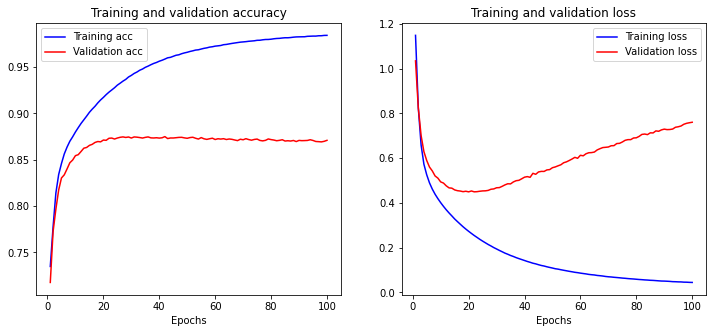

In [28]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel("Epochs")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.xlabel("Epochs")

    plt.title('Training and validation loss')
    plt.legend()
    
plot_history(history)


From the above plots, we see that the validation accuracy hits a hard limit of about .88 even as the training accuracy improves to nearly 1. Interestly, the validitation loss increase after about 10 epochs as the training loss decreases.

## Final thoughts
As someone new to deep learning, NLP, and as such machine translation, this was an incredibly interesting process for me. This class has taught me so far that a lot of the things that I thought of as "magic" before can be done fairly easily using python and its libraries. Google translate was always a mystery to me but I can see how it can be done now. Obviously, the model I made in this notebook is so much simpler than google translate but I can see how the building blocks to create something like google translate can be made. Even if I was able to use a lot more training data and I was able to train the model longer, I can assume that even that would be enough to drastically improve this translation.